## Notes

* the avaliable training datasets from the PlanetScope AnalyticMS_SR are the East Troublesome
and McFarland fires. 

* Drop images with range 0-255

* Cut the images into 4\*32\*32 tiles

* Outpuy the images into training dataset folder

In [1]:
import glob
import numpy as np
import torch
from torch.utils.data import DataLoader
import pandas as pd
from matplotlib import pyplot as plt
import os
from osgeo import gdal
import math
#from PIL import Image
from tqdm import tqdm
import time

/opt/conda/envs/mlenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
#set the normalization parameters (fixed)
min = 0
et_para_list = glob.glob("/home/zbc123a/wildfire/notebooks/Training_Data_Fires/"+"EastTroublesome_stats_B*.csv")
et_para_list.sort()
et_bands_max = []
for et_para in et_para_list:
    df = pd.read_csv(et_para)
    et_bands_max.append(df.Max.max())

mf_para_list = glob.glob("/home/zbc123a/wildfire/notebooks/Training_Data_Fires/"+"McFarland_stats_B*.csv")
mf_para_list.sort()
mf_bands_max = []
for mf_para in mf_para_list:
    df = pd.read_csv(mf_para)
    mf_bands_max.append(df.Max.max())

In [38]:
mf_bands_max

[9157, 8396, 12048, 14796]

In [39]:
et_bands_max

[15428, 25493, 51991, 62883]

In [7]:
max = [15428, 25493, 51991, 62883]
min = [0, 0, 0, 0]

In [2]:
df_et_stats = pd.read_csv("/home/zbc123a/wildfire/notebooks/Training_Data_Fires/EastTroublesome_stats.csv")
df_mf_stats = pd.read_csv("/home/zbc123a/wildfire/notebooks/Training_Data_Fires/McFarland_stats.csv")
df_et_stats_train = df_et_stats.loc[df_et_stats["Max"]!=255,:]
df_mf_stats_train = df_mf_stats.loc[df_mf_stats["Max"]!=255,:]

In [24]:
et_list = ["/home/data/PS_EastTroublesome_AnalyticMS_SR/"+f for f in df_et_stats_train.File.values]

In [25]:
mf_list = ["/home/data/PS_McFarland_AnalyticMS_SR/"+f for f in df_mf_stats_train.File.values]

In [26]:
training_list = et_list+mf_list

In [27]:
len(training_list)

43

In [8]:
band_dict = {1: "Band 1 - Blue", 2: "Band 2 - Green", 3: "Band 3 - Red", 4: "Band 4 - NIR"}

In [9]:
def normalizaed_data(img):
    #min-max normalization of the image based on all images
    #four bands, for different min, max
    max = [15428, 25493, 51991, 62883]
    min = [0, 0, 0, 0]
    img_normalized=np.zeros(img.shape)
    for i in range(4):
        img_normalized[i,:,:]=(img[i,:,:]-min[i])/(max[i]-min[i])
    
    return img_normalized.astype(np.float64)


In [10]:
def recover_data(arr):
    #recover min-max normalized image
    max = [15428, 25493, 51991, 62883]
    min = [0, 0, 0, 0]
    img_recovered=np.zeros(arr.shape)
    for i in range(4):
        img_recovered[i,:,:]=arr[i,:,:]*(max[i]-min[i])+min[i]
    
    return img_recovered.astype(np.float64)

In [11]:
def load_image(img_src,normalization = True):
    '''
    args:
    img_src - directory to the target image

    return:
    data_mtrx - a dictionary of two data matrices for pre and post fire; each of them is in 3 dimensions (band,rows,cols)
    meta_data - metadata includes: transformation, projection, numerber of rows, number of columns, number of bands
    band_dict - band dictionary includes the information of each band
    '''
    
    ps_name = os.path.basename(img_src).split("_")[0]
    loc_name = os.path.basename(img_src).split("_")[1]
    
    print("Loading image: %s - %s" %(loc_name,ps_name))
    
    ds = gdal.Open(img_src)
    ds_arr = ds.ReadAsArray().astype(np.float32)
    
    if normalization:
        ds_arr = normalizaed_data(ds_arr)
    
    print("Loading image is done!")
    return ds_arr,ps_name,loc_name

In [12]:
def create_image_tile(img_src, out_dir, stride_size=32, tile_size = 32):
    '''
    args:
    data_mtrx - a path to 3-dimensional data matrix read from a satellite image

    tile_size - the size of the tile in integer, the default size is 3*3
    stride_size - the size of the stride in integer, for the size of moving pixels for each tile
    output - True/False, whether output the data matrix, the default is False
    out_dir - output directory of the tiled image the default is None. If the ouput is True, the out_dir is required. Output data type should be acceptable for the numpy.save, npy is recommended.

    return:
    data_mtrx_tile - a data matrix of the image after tiling

    '''
    data_mtrx, ps_name, loc_name = load_image(img_src)

    bands, rows, cols = data_mtrx.shape
    
    print("Start tiling the image...")
 
    new_rows = math.floor(1+(rows-tile_size)/stride_size) #asking huiqi to check this one, need to be changed
    new_cols = math.floor(1+(cols-tile_size)/stride_size)
    
    print("The numbers of rows and columns after tiling are (%d, %d)"%(new_rows,new_cols))

    for i in range(new_rows):
        if i<10:
            str_new_rows = '000'+str(i)
        elif i<100:
            str_new_rows = '00'+str(i)
        elif i<1000:
            str_new_rows = '0'+str(i)
        else:
            str_new_rows = str(i)
        for j in range(new_cols):
            if j<10:
                str_new_cols = '000'+str(j)
            elif j<100:
                str_new_cols = '00'+str(j)
            elif j<1000:
                str_new_cols = '0'+str(j)
            else:
                str_new_cols = str(j)
            cropped_arr = data_mtrx[:,i*stride_size : (i*stride_size+tile_size), j*stride_size : (j*stride_size+tile_size)]
            cropped_arr[cropped_arr==0.0]=np.nan
            if np.isnan(cropped_arr).sum() == 0:
                output_file = os.path.join(out_dir,loc_name+"_"+ps_name+"_"+str_new_rows+"_"+str_new_cols+".npy")
                np.save(output_file, cropped_arr)
            if i == 0 and j==0:
                print("After tiling, the size of data matrix becomes: ", cropped_arr.shape)
    del data_mtrx, cropped_arr

In [29]:
for tr_f in training_list:
    start = time.time()
    create_image_tile(tr_f,out_dir = "/home/data/PS_Training")
    print("Done. %.2f mintues" %((time.time()-start)/60))

Loading image: EastTroublesome - PlanetScope20201003
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (322, 607)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 0.58 mintues
Loading image: EastTroublesome - PlanetScope20201006
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (322, 607)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 1.05 mintues
Loading image: EastTroublesome - PlanetScope20201009
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (322, 607)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 1.24 mintues
Loading image: EastTroublesome - PlanetScope20201016
Loading image is done!
Start tiling the image...
The numbers of rows and columns after tiling are (322, 607)
After tiling, the size of data matrix becomes:  (4, 32, 32)
Done. 1.27 mintues
Loading image: EastTroublesome - Pla

In [37]:
test = np.load("/home/data/PS_Training/McFarland_PlanetScope20210825_0200_0423.npy")
test = test*10

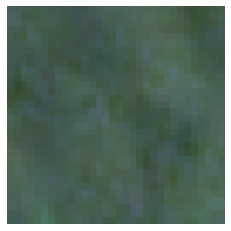

In [38]:
plt.figure()
plt.imshow(np.moveaxis(test[[2,1,0],:,:],0,-1))
plt.axis("off")
plt.show()

In [38]:
test_list = glob.glob("/home/zbc123a/PS_Training_Data/"+"*.npy")

In [39]:
len(test_list)

4382607